In [1]:
from astropy.io import fits
import os
from astropy import units as u
from astropy import constants as const

In [2]:
def brakett_wavelength(n):
    
    Rh = 1.09737e7 * u.Unit('m^-1')
    l_inv = Rh*( (1/4**2) - (1/n**2) )
    return (1/l_inv).to('AA')

def plotparams(ax, labelsize=15):
    '''
    Basic plot params

    :param ax: axes to modify

    :type ax: matplotlib axes object

    :returns: modified matplotlib axes object
    '''

    if isinstance(ax, np.ndarray):
        for a in ax.reshape(-1):
            plotparams(a)
        return

    ax.minorticks_on()
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(direction='in', which='both', labelsize=labelsize)
    ax.tick_params('both', length=8, width=1.8, which='major')
    ax.tick_params('both', length=4, width=1, which='minor')
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)
    return ax

In [3]:
fnames = [ f for f in os.listdir() if f.startswith('apVisit') ]
#Pick single spectrum for now
fname = fnames[0]

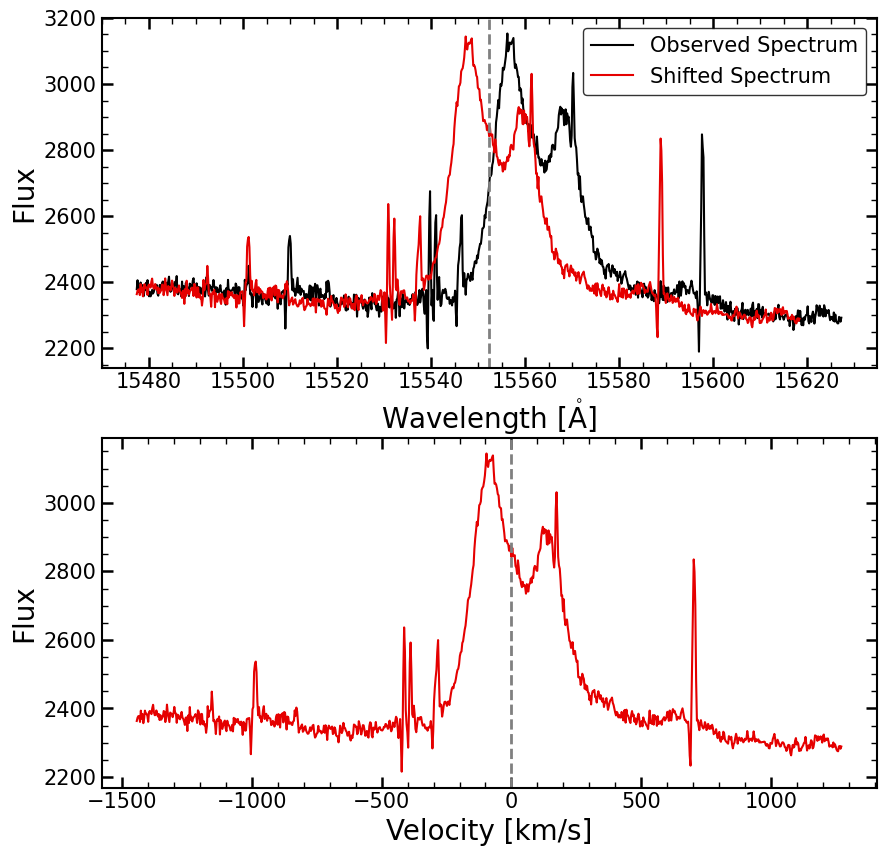

In [4]:
#Read in to pandas df
hdul = fits.open(fname)
wavelengths = np.concatenate([hdul[4].data[i,:] for i in range(hdul[1].data.shape[0]) ])
fluxes = np.concatenate([hdul[1].data[i,:] for i in range(hdul[1].data.shape[0])])
df_spec = pd.DataFrame({'wavelength': wavelengths, 'flux':fluxes}).sort_values(by='wavelength')
df_spec = df_spec.reset_index(drop=True)

#I chose n=16 here. Trim dataframe
ll = brakett_wavelength(16)
#wavelength_range = (15500, 15650)
wavelength_range = (ll.value-75, ll.value+75)
idx = np.where( (df_spec.wavelength > wavelength_range[0]) & (df_spec.wavelength < wavelength_range[1]))[0]
df_spec = df_spec.iloc[idx].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(df_spec.wavelength, df_spec.flux, color='black', label='Observed Spectrum')


################ Shift the spectrum to correct radial velocity ##################
rv = -170 #in km/s
c = 299792458.0 #speed of light m/s

#doppler shift
factor = 1 / (1 + (rv * 1000.) / c)

#the shifted wavelengths are spec.df.wavelength/factor, but 
#we want to realign them with the observed fluxes,
#so we need to interpolate
shifted = np.interp(df_spec.wavelength,
                    df_spec.wavelength/factor,
                    df_spec.flux,
                    left=np.nan, right=np.nan)

df_spec['flux'] = shifted
df_spec = df_spec[~df_spec.flux.isna()].reset_index(drop=True)

#Plot the shifted spec
ax[0].plot(df_spec.wavelength, df_spec.flux, color='xkcd:red', label='Shifted Spectrum')

############## Convert wavelength to velocity ##############
#If we want to make the x-axis velocity, instead of wavelength
rest_wavelength = ll

#Doppler shift again
vel = const.c * (df_spec.wavelength.values*u.AA - rest_wavelength) / rest_wavelength
vel = vel.to('km/s').value
ax[1].plot(vel, df_spec.flux, color='xkcd:red')

#Various plotting things
ax[0] = plotparams(ax[0])
ax[1] = plotparams(ax[1])

ax[0].set_xlabel(r'Wavelength [{}]'.format(f'{u.AA:latex}'), fontsize=20)
ax[0].set_ylabel('Flux', fontsize=20)
ax[1].set_xlabel('Velocity [km/s]', fontsize=20)
ax[1].set_ylabel('Flux', fontsize=20)

ax[0].axvline(ll.value, lw=2, ls='--', color='gray')
ax[1].axvline(0.0, color='gray', lw=2, ls='--')

ax[0].legend(loc='upper right', edgecolor='black', fontsize=15)
